In [65]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
import sys

sys.stdin.encoding
sys.stdout.encoding

'UTF-8'

In [67]:
def get_flow(path, src_ip, dst_ip):
    data = pd.read_csv(path)
    raw_data = data.values

    clean_data = []
    flows = []

    # 패킷의 전송 간격을 구함
    interval = []
    last = 0
    for line in raw_data:
        if line[2] == src_ip or line[2] == dst_ip:
            interval.append(line[1]-last)
            last = line[1]
            clean_data.append(line)

    # 패킷 평균 전송 간격
    avg = sum(interval) / len(interval)

    diverge = []

    i = 0
    # 평균 전송간격보다 큰 경우 flow를 분리를 위한 인덱스 찾기
    for t in interval:
        if t >= avg:
            diverge.append(i)
        i = i + 1

    # 찾은 인덱스로 flow를 분리
    prefix = 0
    for idx in diverge:
        if idx >= len(clean_data):
            break
        flow = clean_data[prefix:idx]
        flows.append(flow)
        prefix = idx + 1

    print("## 총 ", len(flows), "개의 flow 발견")

    # 평균 인터벌
    avg_ivl = []
    # 평균 페이로드 크기
    avg_pay = []
    # 평균 패킷 수
    avg_cnt = []
    # 프로토콜 넘뻐
    pcl = []

    for flow in flows:
        last = 0
        ivl = 0
        payload = 0
        if len(flow) <= 0:
            continue
        for line in flow:
            ivl = ivl + (line[1]-last)
            last = line[1]
            payload = payload + line[5]

        # 값 입력
        avg_ivl.append(ivl / len(flow))
        avg_pay.append(payload / len(flow))
        avg_cnt.append(len(flow))
        if flow[0][4] == "UDP":
            pcl.append(17)
        elif flow[0][4] == "TCP":
            pcl.append(6)

    return (np.array([avg_ivl, avg_cnt, avg_pay, pcl])).T


In [68]:
nor_flow = get_flow("./datasets/pingFlood5m-1h_.csv", '172.27.224.250', '172.27.224.251')
ab_flow = get_flow("./datasets/pingFlood5m-1h_ab.csv", '172.27.224.250', '172.27.224.251')

## 총  3413 개의 flow 발견
## 총  208 개의 flow 발견


In [69]:
from sklearn.preprocessing import MinMaxScaler

In [70]:
scaler = MinMaxScaler()
scaler.fit(nor_flow)
nor_flow = scaler.transform(nor_flow)

In [71]:
scaler.fit(ab_flow)
ab_flow = scaler.transform(ab_flow)

In [72]:
nor_flow = pd.DataFrame({'interval': nor_flow[:, 0], 'count': nor_flow[:, 1], 'size': nor_flow[:, 2], 'proto': nor_flow[:, 3], 'label': 0})
ab_flow = pd.DataFrame({'interval': ab_flow[:, 0], 'count': ab_flow[:, 1], 'size': ab_flow[:, 2], 'proto': ab_flow[:, 3], 'label':1 })

In [73]:
full_data = pd.concat([nor_flow, ab_flow])

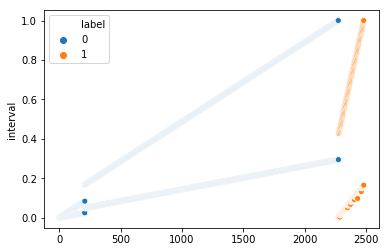

In [74]:
sns.scatterplot(x=range(len(full_data['interval'])), y=full_data['interval'], hue=full_data['label'])

In [75]:
from sklearn.cluster import KMeans, DBSCAN

In [76]:
X = full_data.drop(['label'], axis=1)
Y = full_data['label']

In [77]:
kmeans = KMeans(n_clusters=2).fit(X.values)
X['cid'] = kmeans.labels_

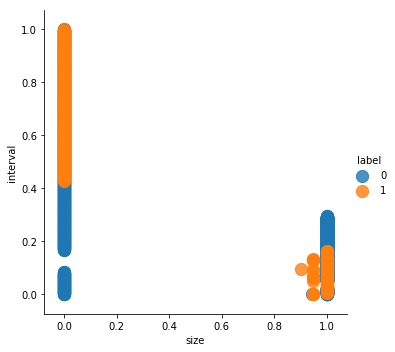

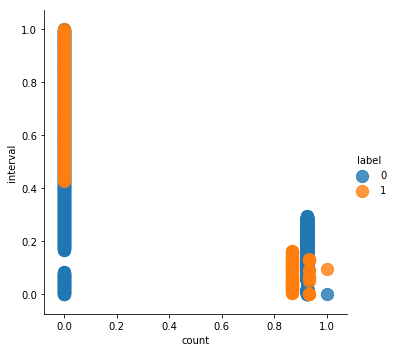

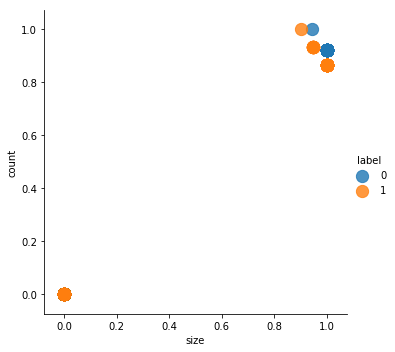

In [78]:
sns.lmplot('size', 'interval', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')
sns.lmplot('count', 'interval', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')
sns.lmplot('size', 'count', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')

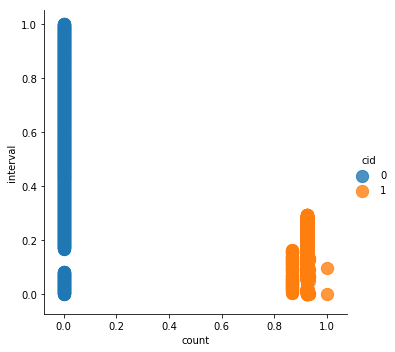

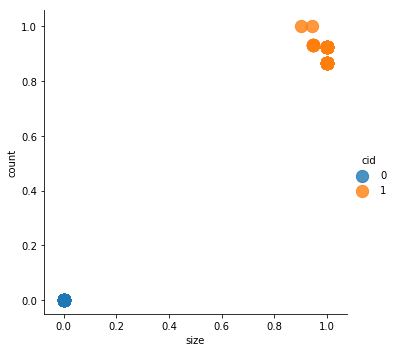

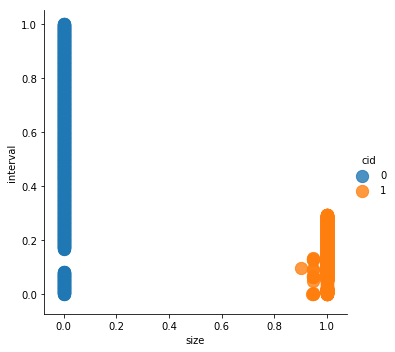

In [79]:
sns.lmplot('count', 'interval', data=X, fit_reg=False, scatter_kws={'s':150}, hue='cid')
sns.lmplot('size', 'count', data=X, fit_reg=False, scatter_kws={'s':150}, hue='cid')
sns.lmplot('size', 'interval', data=X, fit_reg=False, scatter_kws={'s':150}, hue='cid')

In [80]:
y_pred = list(kmeans.labels_)
scoreY = list(Y)
hit = 0
for i in range(0, len(y_pred)):
    if y_pred[i] == scoreY[i]:
        hit = hit + 1
print(hit/len(scoreY))

0.5


In [81]:
X = X.drop(['cid'], axis=1)

In [82]:
dbscan = DBSCAN(eps=0.04, min_samples=30).fit(X)

In [83]:
y_pred = dbscan.fit_predict(X)
X['cid'] = y_pred

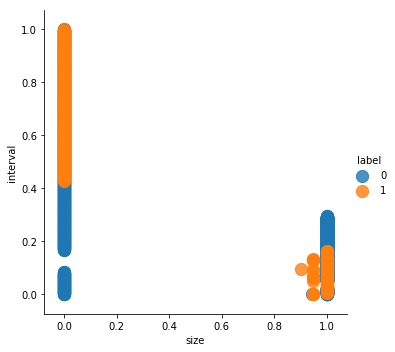

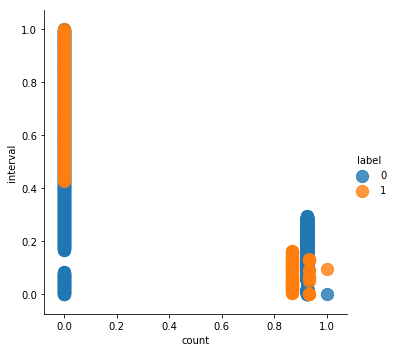

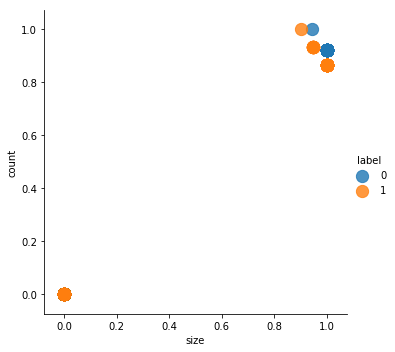

In [84]:
sns.lmplot('size', 'interval', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')
sns.lmplot('count', 'interval', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')
sns.lmplot('size', 'count', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')

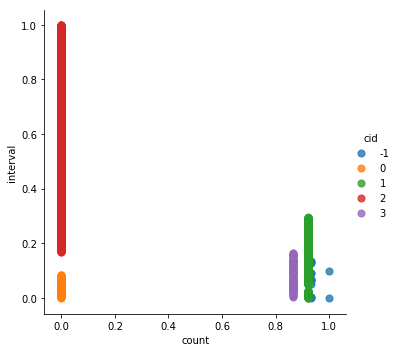

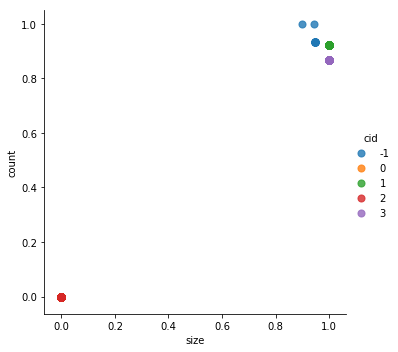

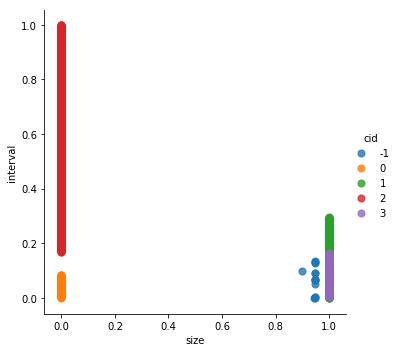

In [85]:
sns.lmplot('count', 'interval', data=X, fit_reg=False, scatter_kws={'s':50}, hue='cid')
sns.lmplot('size', 'count', data=X, fit_reg=False, scatter_kws={'s':50}, hue='cid')
sns.lmplot('size', 'interval', data=X, fit_reg=False, scatter_kws={'s':50}, hue='cid')

In [86]:
hit = 0
for i in range(0, len(y_pred)):
    if (y_pred[i] + scoreY[i]) == 0:
        hit = hit + 1
print(hit/len(scoreY))

0.04794520547945205


In [87]:
import tensorflow as tf
import time
from dagmm import DAGMM

In [88]:
full_data = pd.concat([nor_flow, ab_flow])
X = full_data.drop(['label'], axis=1)

In [89]:
full_data

,count,interval,label,proto,size
0,1.000000,0.000000,0,0.0,0.944444
1,0.000000,0.000407,0,0.0,0.000000
2,0.923077,0.000237,0,0.0,1.000000
3,0.000000,0.001210,0,0.0,0.000000
4,0.923077,0.000474,0,0.0,1.000000
5,0.000000,0.002017,0,0.0,0.000000
6,0.923077,0.000711,0,0.0,1.000000
7,0.000000,0.002824,0,0.0,0.000000
8,0.923077,0.000948,0,0.0,1.000000
9,0.000000,0.003630,0,0.0,0.000000


In [25]:
tf.reset_default_graph()

In [26]:
model_dagmm = DAGMM(
    comp_hiddens=[16,8,1], comp_activation=tf.nn.tanh,
    est_hiddens=[8,4], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=1000, minibatch_size=36
)

In [27]:
start = time.time()
model_dagmm.fit(X)
end = time.time()
print("Learning time = ", end-start)

 epoch 100/1000 : loss = 0.207
 epoch 200/1000 : loss = 0.014
 epoch 300/1000 : loss = -0.045
 epoch 400/1000 : loss = -0.065
 epoch 500/1000 : loss = -0.088
 epoch 600/1000 : loss = -0.111
 epoch 700/1000 : loss = -0.131
 epoch 800/1000 : loss = -0.141
 epoch 900/1000 : loss = -0.151
 epoch 1000/1000 : loss = -0.160
Learning time =  515.8419370651245


In [28]:
energy = model_dagmm.predict(X)

Text(0, 0.5, 'Number of Sample(s)')

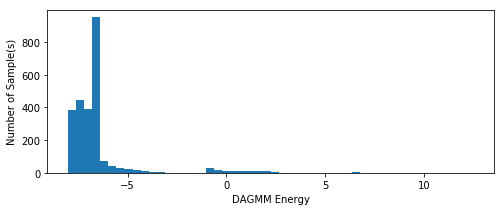

In [29]:
plt.figure(figsize=[8,3])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")

In [30]:
energy.sort()
threshold = len(energy)*0.1
print(threshold)
threshold = energy[-int(threshold)]
print(threshold)
cid = []
for node in energy:
    if node > threshold:
        cid.append(1)
    else:
        cid.append(0)

248.20000000000002
-6.075657


In [31]:
X['cid'] = cid
X['energy'] = energy
X['label'] = Y

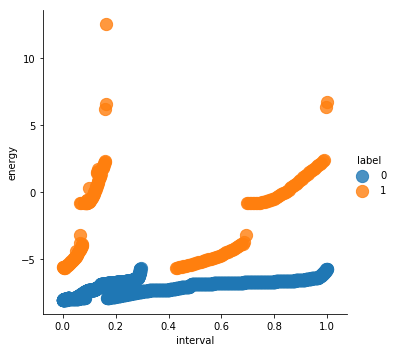

In [32]:
sns.lmplot('interval', 'energy', data=X, fit_reg=False, scatter_kws={'s':150}, hue='label')

In [33]:
y_pred = list(X['cid'])
scoreY = list(X['label'])
hit = 0
for i in range(0, len(y_pred)):
    if y_pred[i] == scoreY[i]:
        hit = hit + 1
print(hit/len(scoreY))

0.983883964544722


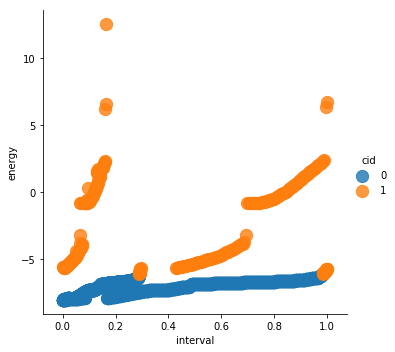

In [34]:
sns.lmplot('interval', 'energy', data=X, fit_reg=False, scatter_kws={'s':150}, hue='cid')